In [31]:
import numpy as np
import pandas as pd
import mygene
import omnipath as op
import matplotlib.pyplot as plt
import seaborn as sns
import mellon as ml
import random
import networkx as nx

In [32]:
# import gtex expression data

gtex_link = 'raw_data/GTEx_tissue_data/GTEx_Analysis_2017-06-05_v8_RNASeQCv1.1.9_gene_median_tpm.gct.gz'
exp = pd.read_csv(gtex_link, sep='\t', index_col='Description', skiprows=2)
exp_cns = exp

# import omnipath db
db = op.interactions.import_intercell_network(transmitter_params = {"categories":"ligand"}, receiver_params = {"categories": "receptor"})
db = db[np.logical_not(db['genesymbol_intercell_source'].str.startswith('HLA'))]
db = db[np.logical_not(db['genesymbol_intercell_target'].str.startswith('HLA'))]
db = db[~db['genesymbol_intercell_target'].astype(str).str.startswith('COMPLEX')]
db = db[~db['genesymbol_intercell_source'].astype(str).str.startswith('COMPLEX')]

In [33]:
braingenes = exp_cns.index.dropna()
braingenes
#all_source, pctsrc, all_targets, pcttgt, summary_LR = ml.lr.find_hits(pd.DataFrame(braingenes, index = list(braingenes)),db)
#brainLR = pd.concat([all_source['gene'],all_targets['gene']], axis = 0).unique()

Index(['DDX11L1', 'WASH7P', 'MIR6859-1', 'MIR1302-2HG', 'FAM138A', 'OR4G4P',
       'OR4G11P', 'OR4F5', 'RP11-34P13.7', 'CICP27',
       ...
       'MT-ND4', 'MT-TH', 'MT-TS2', 'MT-TL2', 'MT-ND5', 'MT-ND6', 'MT-TE',
       'MT-CYB', 'MT-TT', 'MT-TP'],
      dtype='object', name='Description', length=56200)

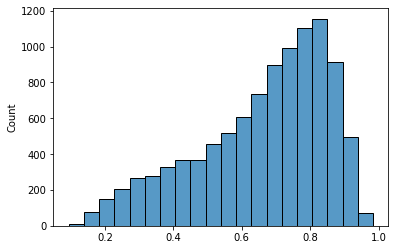

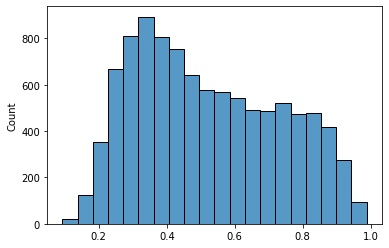

No LRs in list
No LRs in list
No LRs in list
No LRs in list
No LRs in list
No LRs in list
No LRs in list
No LRs in list
No LRs in list
No LRs in list


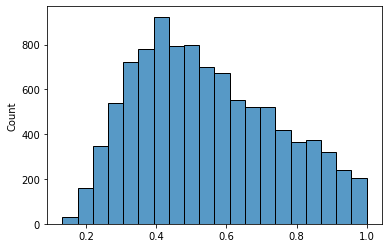

In [48]:

reslist = [0.40, 0.55, 0.70]
iter = 10000
genes = pd.read_csv('processed_data/hot-encoded-diseases_0.400000.csv')['genes']
universe = list(set(braingenes).difference(set(list(genes)).intersection(set(braingenes))))

for res in range(0,len(reslist)):
    if (reslist[res]!=0.55):
        genes = pd.read_csv('processed_data/hot-encoded-diseases_%s00000.csv' % reslist[res])
    if (reslist[res]==0.55):
        genes = pd.read_csv('processed_data/hot-encoded-diseases_%s0000.csv' % reslist[res])
    boot = []
    for i in range (0,iter):
            rand = random.sample(range(0,len(universe)), np.shape(genes)[0])
            brainSubset = pd.DataFrame(universe).iloc[rand]
            LRs = db[['genesymbol_intercell_source','genesymbol_intercell_target']][(db['genesymbol_intercell_source'].isin(list(brainSubset[0]))) | (db['genesymbol_intercell_target'].isin(list(brainSubset[0])))]
            LRs = LRs.dropna()
            unique_genes = list(pd.concat([LRs['genesymbol_intercell_source'],LRs['genesymbol_intercell_target']], axis = 0).unique())
            adj_LRs = pd.DataFrame(np.zeros(shape=(len(unique_genes), len(unique_genes))), index = unique_genes, columns = unique_genes)
            for n in range (0, np.shape(LRs)[0]):
                adj_LRs.iloc[adj_LRs.index.get_loc(LRs.iloc[n]['genesymbol_intercell_source']), adj_LRs.columns.get_loc(LRs.iloc[n]['genesymbol_intercell_target'])] += 1
            # Create network and detect communities
            if (len(adj_LRs)<1):
                print('No LRs in list')
            else:
                H = nx.from_pandas_adjacency(adj_LRs)
                comms = ml.network.louvain_communities(H, seed = 123, resolution = 0.01)

                # Check which is the largest network and save % of total LRs in network
                for l in range(0,len(comms)):
                    this = len(comms[l])
                    
                    if (l == 0):
                        longest = this
                        cluster = comms[l]
                    elif (this > longest):
                        longest = this
                        cluster = comms[l]
                    
                boot.append(longest/len(H))
                del adj_LRs
                del LRs

    sns.histplot(data = boot, bins = 20)
    plt.savefig('plots/03-LR_network_visualisation/03d_network_stats_per_threshold/hist_distribution_%s.png' % reslist[res], dpi=150)
    plt.show()

    if (res==0):
        results = pd.DataFrame(boot, columns = [reslist[res]])
    else: 
       results = pd.concat([results, pd.DataFrame(boot, columns = [reslist[res]])], axis = 1)

results.to_csv('processed_data/03-LR_network_visualisation/03d_network_stats_per_threshold/bootstrapped_results_10000iter_%majornetwork.csv')
            
#

In [49]:
occurance = pd.read_csv('processed_data/03-LR_network_visualisation/03l_visualise_networks/%_genes_in_major_network.csv')



In [50]:
(results[0.40]>occurance['0.400000'][0]).sum()/iter

0.001

In [51]:
(results[0.55]>occurance['0.550000'][0]).sum()/iter

0.0067

In [ ]:
(results[0.7]>occurance['0.700000'][0]).sum()/iter

0.2276